# Predicting Bike Rentals

## Introduction to the Dataset

Many U.S. cities have communal bike-sharing stations where we can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

The CSV file used in this project contains `17379` rows, with each row representing the number of bike rentals for a single hour of a single day. It can be downloaded from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

- **`instant`:** A unique sequential ID number for each row
- **`dteday`:** The date of the rentals
- **`season`:** The season in which the rentals occurred
- **`yr`:** The year the rentals occurred
- **`mnth`:** The month the rentals occurred
- **`hr`:** The hour the rentals occurred
- **`holiday`:** Whether or not the day was a holiday
- **`weekday`:** The day of the week (as a number, 0 to 7)
- **`workingday`:** Whether or not the day was a working day
- **`weathersit`:** The weather (as a categorical variable)
- **`temp`:** The temperature, on a 0-1 scale
- **`atemp`:** The adjusted temperature
- **`hum`:** The humidity, on a 0-1 scale
- **`windspeed`:** The wind speed, on a 0-1 scale
- **`casual`:** The number of casual riders (people who hadn't previously signed up with the bike sharing scheme)
- **`registered`:** The number of registered riders (people who had already signed up)
- **`cnt`:** The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the **`cnt`** column using all of the other columns, except for **`casual`** and **`registered`**. To accomplish this, we'll create a few different machine learning models and evaluate their performances.

Let's start with reading in the dataset and doing some initial investigation of the data.

In [1]:
import pandas as pd

# Read in the dataset and visualise the first few rows
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


We'll make a histogram of the `cnt` column and take a look at the *distribution* of total bike rentals.

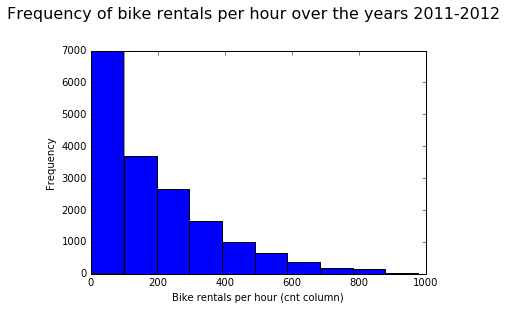

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(bike_rentals['cnt'])
plt.xlabel('Bike rentals per hour (cnt column)')
plt.ylabel('Frequency')
plt.text(x=-250, y=8000, 
         s='Frequency of bike rentals per hour over the years 2011-2012',
        size=16)
plt.show()

Looking at the histogram we generated for the **`cnt`** column, we can make a few quick observations about the following:

- *Range*: Over the two years (2011 and 2012), the values ranged between 0 and 1,000 bike rentals per hour.


- The *distribution* of the bike rentals:
  - Most typically, the number of bike rentals per hour varies between 1 and 100.
  - For most of the single hours of each day, the number of bike rentals ranges between 1 and 400.
  - Most uncommonly, the number of bike rentals per hour goes over 400.
  
  
Below we see how each column is correlated with **`cnt`** column.

In [3]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Calculating Features

The **`hr`** column contains the hours during which bikes are rented, from **`0`** to **`23`**. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with categorical labels. This bundles similar times together, enabling the model to make better decisions.

We'll write a function called **`assign_label`** that takes in a numeric value for an hour, and returns:
 - **`1`** if the hour is from **`6`** to **`12`**
 - **`2`** if the hour is from **`12`** to **`18`**
 - **`3`** if the hour is from **`18`** to **`24`**
 - **`4`** if the hour is from **`0`** to **`6`**
 
Then we will apply the function to each item in the **`hr`** column and assign the result to a new column called **`time_label`**. 

In [4]:
# Create the function that returns categorical labels
def assign_label(hour):
    if hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour < 24:
        return 3
    elif hour >= 0 and hour < 6:
        return 4
    
# Apply the function and assign the results to a new column
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

# Check how the new column is correlated with 'cnt' column
bike_rentals.corr()['cnt']['time_label']

-0.3783183000693379

## Splitting the data into Train and Test Sets

Before we begin applying machine learning algorithms, we'll split the data into *training* and *testing* sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set.

We will select 80% of the rows in the dataset to be part of the *training* set and the remaining rows to be part of the *testing* set.

In [5]:
# Select randomly 80% of the rows in 'bike_rentals'
train = bike_rentals.sample(frac=0.8, random_state=1)

# Select the rows that are in 'bike_rentals' but not in 'train'
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Machine Learning Algorithms and Error Metric

Since the **`cnt`** column contains numeric values, the following machine learning algorithms will be used for modelling:

- Linear Regression
- Decision Tree Regression
- Random Forest Regression

Our exploration of the **`cnt`** column showed us the absence of outliers. Given that, the RMSE is a good choice of an error metric to evaluate the performance of the different models.

In addition, the RMSE is particularly useful for comparing the fit of different regression models and its interpretation is easy, the lower the RMSE, the better a given model is able to “fit” a dataset.

We will apply all the machine learning algorithms mentioned above using only their *default* settings and compare which one performs better on our dataset.

In [6]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Select features and target columns
features = train.columns.drop(['dteday', 'casual', 'registered', 'cnt'])
target = 'cnt'

## Applying Linear Regression

In [7]:
# Instantiate the model
lr = LinearRegression()

# Fit the model on the train set
lr.fit(train[features], train[target])

# Make predictions on the test set
lr_predictions = lr.predict(test[features])

# Compute the error between predictions and actual values
lr_mse = mean_squared_error(test[target], lr_predictions)
lr_rmse = np.sqrt(lr_mse)
print('RMSE using Linear Regression is: {}'.format(lr_rmse))

RMSE using Linear Regression is: 130.5837848710458


## Applying Decision Tree

In [8]:
# Instantiate the model
dt = DecisionTreeRegressor(random_state=1)

# Fit the model on the train set
dt.fit(train[features], train[target])

# Make predictions on the test set
dt_predictions = dt.predict(test[features])

# Compute the error between predictions and actual values
dt_mse = mean_squared_error(test[target], dt_predictions)
dt_rmse = np.sqrt(dt_mse)
print('RMSE using Decision Tree is: {}'.format(dt_rmse))

RMSE using Decision Tree is: 56.775183499923116


## Applying Random Forests

In [9]:
# Instantiate the model
rf = RandomForestRegressor(random_state=1)

# Fit the model on the train set
rf.fit(train[features], train[target])

# Make predictions on the test set
rf_predictions = rf.predict(test[features])

# Compute the error between predictions and actual values
rf_mse = mean_squared_error(test[target], rf_predictions)
rf_rmse = np.sqrt(rf_mse)
print('RMSE using Random Forest is: {}'.format(rf_rmse))

RMSE using Random Forest is: 45.66435871116254


## Conclusion

Among the above models, Random Forest has shown the best result when each of them has been applied using only their *default* settings. Below are a few reasons that comply with the obtained result.

 - Linear regression works best when features are linearly correlated to the target column.

 - Decision trees tend to predict outcomes much more reliably than linear regression models because a decision tree is a fairly complex model.

 - Random forest algorithm, which improves on the decision tree algorithm, tends to be much more accurate than simple models like linear regression.